## Week 3: CNN Cancer Detection Kaggle Mini-Project

### Problem Description
The "Histopathologic Cancer Detection" challenge on Kaggle is a **Binary Image Classification** problem. The project's goal is to develop a machine learning model to **automatically identify** the presence of **metastatic cancer** in small image patches derived from larger digital pathology scans.

* **Required Output:** The model must predict a **binary label** for each image patch:
    * **1 (Positive):** The image patch contains at least one pixel of tumor tissue within the center $32 \times 32$ region.
    * **0 (Negative):** The image patch does not contain tumor tissue in the center $32 \times 32$ region.


### Data Description
The data for this competition is a slightly modified version of the well-known **PatchCamelyon (PCam)** benchmark dataset.
* **Modification:** The original PCam dataset contained duplicate images due to its probabilistic sampling method. The version presented on Kaggle **does not contain duplicates**, though the core data and splits remain consistent with the PCam 

#### Size and Structure
* **Total Files:** **277,485** image files.
* **Total Size:** **7.76 GB**.
* **File Types:** **`.tif`** image files and a **`.csv`** label file.

#### Dimensions and Format
* **Image Format:** The files are in `.tif` (Tagged Image File Format), a common format in medical imaging.
* **Patch Size:** Each image patch has a dimension of $96 \times 96$ pixels.
* **Color Channels:** The images are **RGB** (3 color channels), resulting in a tensor dimension of **$(96, 96, 3)$** per image.
* **Labeling Rule:** The positive label is determined by the presence of tumor tissue within the **center $32 \times 32$ region** of the patch. The outer region serves as padding to enable fully-convolutional models without zero-padding.

### Proposed Approach
The challenge presents a relatively **large dataset** ($7.76\text{ GB}$ with $277,485$ images) compared to a standard student project.
Therefore, the chosen primary solution will utilize **Transfer Learning** with **Freezing Initial Layers** based on pre-trained **Deep Convolutional Neural Networks (CNNs)** from the ImageNet dataset. The models selected for analysis are: **ResNet50** and **VGG16 (or VGG19)**.

## 🔬 1. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

### 2.1. Data Cleaning and Integrity

A crucial step of initial data cleaning was **pre-performed by the competition host**. This inherent cleaning ensures high data integrity regarding duplicates, allowing the project to focus on pre-processing required for Deep Learning rather than heavy data cleaning.

### 1.2. Class Distribution Analysis

**Procedure:** We load the `train_labels.csv` file and count the occurrence of each label (0 and 1).
* **Visualization:** The bar plot below clearly illustrates this distribution: The Non-Cancer class (Label 0) having a higher representation than the Cancer class (Label 1). The analysis shows a slight **class imbalance**. 

### 1.3. Visual Inspection of Image Patches
* **Visualization:** A grid of sample images is generated to show the visual difference between the two classes.

Total number of training samples: 220025
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

--- 2.2. Class Distribution ---
label
0    130908
1     89117
Name: count, dtype: int64


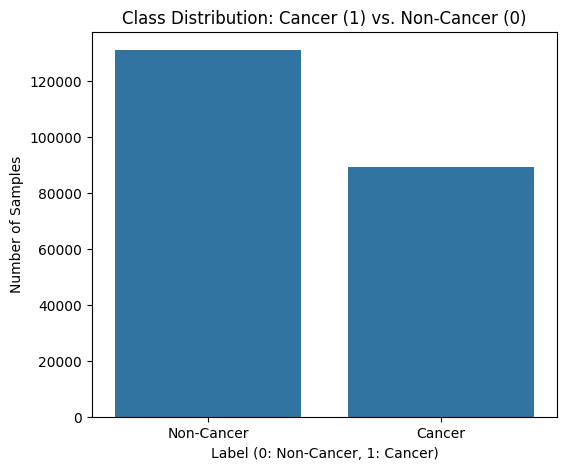

Observation: The data shows a slight class imbalance.


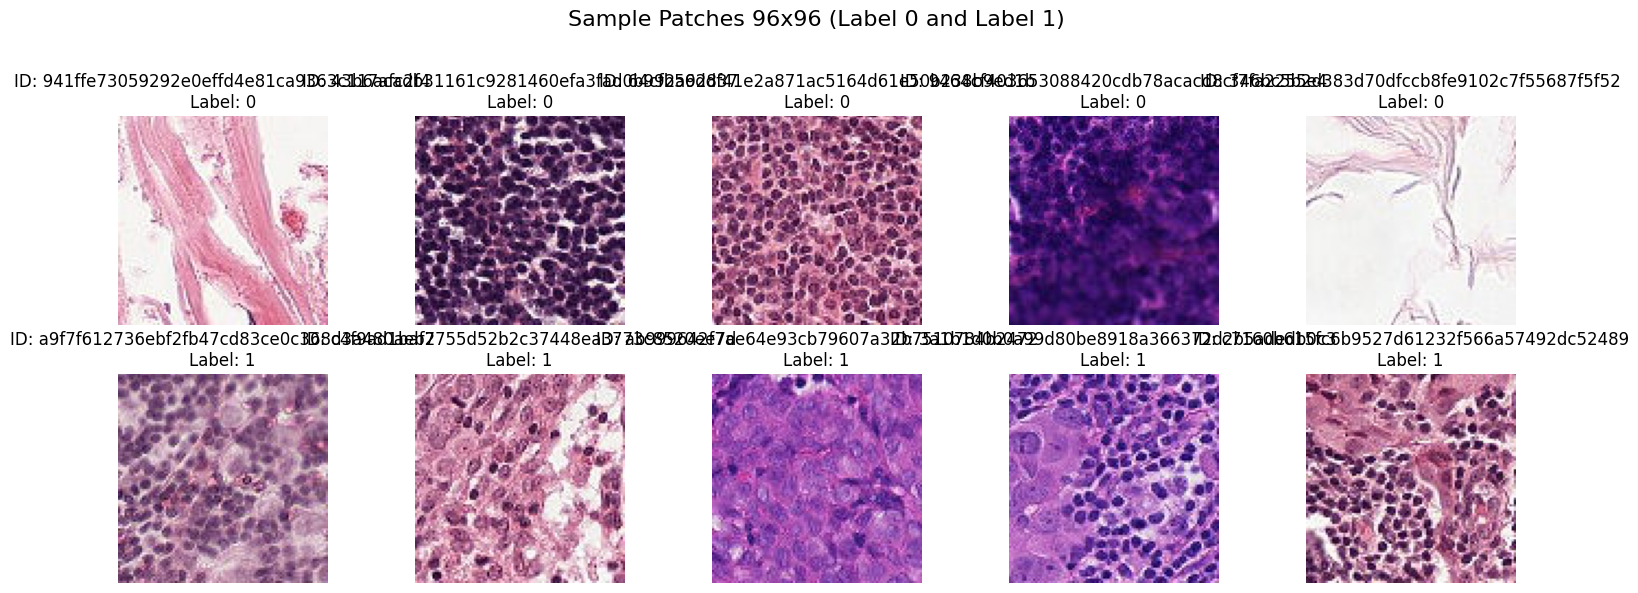

Calculated Class Weights: {0: 0.840380267057781, 1: 1.234472659537462}


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # <-- Added for Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

INPUT_DIR = '../data/'
TRAIN_DIR = os.path.join(INPUT_DIR, 'train')
LABEL_FILE = os.path.join(INPUT_DIR, 'train_labels.csv')

# Standard image size for the PCam dataset
IMAGE_SIZE = 96

# --- 2. Data Statistics and Class Distribution (EDA) ---
train_df = pd.read_csv(LABEL_FILE)
print(f"Total number of training samples: {len(train_df)}")
print(train_df.head())

# Count samples for each class
class_counts = train_df['label'].value_counts()
print("\n--- 2.2. Class Distribution ---")
print(class_counts)

# Visualize Class Distribution
plt.figure(figsize=(6, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution: Cancer (1) vs. Non-Cancer (0)')
plt.xlabel('Label (0: Non-Cancer, 1: Cancer)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Non-Cancer', 'Cancer'])
plt.show()
print("Observation: The data shows a slight class imbalance.")


# --- 3. Image Visualization --
# Sample 5 patches for each class
sample_0 = train_df[train_df['label'] == 0]['id'].sample(5, random_state=42).tolist()
sample_1 = train_df[train_df['label'] == 1]['id'].sample(5, random_state=42).tolist()
sample_ids = sample_0 + sample_1

plt.figure(figsize=(15, 6))
plt.suptitle(f"Sample Patches {IMAGE_SIZE}x{IMAGE_SIZE} (Label 0 and Label 1)", fontsize=16)

for i, img_id in enumerate(sample_ids):
    # Construct the image file path
    img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
    
    # Get the image label
    label = train_df[train_df['id'] == img_id]['label'].iloc[0]
    
    try:
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {img_id}\nLabel: {label}")
        plt.axis('off')
    except FileNotFoundError:
        print(f"Error: Image file not found for ID {img_id}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- 4. Data Pre-processing and Analysis Plan ---
y_train = train_df['label'].values
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

print(f"Calculated Class Weights: {class_weights}")



## 2. Model Architecture and Reasoning 

The complexity of histopathological features and the need for resource efficiency in the Kaggle environment necessitate the use of **Transfer Learning** with deep Convolutional Neural Networks (CNNs). We selected and compared two pre-trained architectures—**ResNet50** and **VGG16**—both initialized with **ImageNet weights**.

### 3. Customized Architecture and Strategy

Both base models are modified and trained using a two-stage strategy tailored for the PCam dataset:

| Component | Detail | Reasoning |
| :--- | :--- | :--- |
| **Input** | $96 \times 96 \times 3$ (RGB) | Matches PCam data dimensions; Normalized by ImageNet stats. |
| **Classification Head** | Global Average Pooling $\rightarrow$ Dense (128 units, ReLU, Dropout 0.5) $\rightarrow$ Output (1 unit, Sigmoid) | Simplifies parameter count and customizes the output for the binary classification task (Cancer vs. Non-Cancer). |
| **Training Phase 1 (Frozen)** | Base layers frozen. Trained for $\sim$5 epochs with $\text{LR} = 10^{-3}$. | **Optimizes Resource Usage:** Freezing the convolutional base saves significant GPU time and memory in the initial phase while training the new classification head. |
| **Training Phase 2 (Fine-Tuning)** | Last layers unfrozen. Trained for $\sim$10-15 epochs with $\text{LR} = 10^{-5}$. | **Maximizes Performance:** Allows the model to adapt its internal feature weights specifically to the unique visual characteristics of histopathology images, balancing generalization and specialization. |

The evaluation will use the **Area Under the ROC Curve (AUC)**, the competition's metric, as it provides a robust measure of performance on imbalanced classification tasks.

In [ ]:
# ==============================================================================
# --- 5. Hyperparameters and Data Generator Setup (PHASE 1) ---
# ==============================================================================

# Split dataset for train set / validate set
# Split the dataframe into Training (80%) and Validation (20%)
# Stratify=y_train ensures that both sets maintain the same class ratio to handle imbalance
# We will use the full training set (train_df) for this split
y_full = train_df['label']
X_full = train_df['id']

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, 
    test_size=0.20,      # 20% for validation
    stratify=y_full,     # Crucial for maintaining class balance in both sets
    random_state=42      # For reproducibility
)

# Convert split results back to DataFrames for easier use with ImageDataGenerator
train_df_split = pd.DataFrame({'id': X_train, 'label': y_train}).reset_index(drop=True)
val_df_split = pd.DataFrame({'id': X_val, 'label': y_val}).reset_index(drop=True)

# Add .tif extension to IDs for generator compatibility
train_df_split['id'] = train_df_split['id'].apply(lambda x: x + '.tif')
val_df_split['id'] = val_df_split['id'].apply(lambda x: x + '.tif')

# FIX: Convert both Training and Validation labels to string for class_mode='binary'
train_df_split['label'] = train_df_split['label'].astype(str)
val_df_split['label'] = val_df_split['label'].astype(str)



# Define Hyperparameters for the initial, frozen phase
BATCH_SIZE = 64 
INITIAL_EPOCHS = 8 
LEARNING_RATE_PHASE_1 = 1e-3 # Faster LR for training the new head

# --- 5.1. Data Augmentation and Pre-processing ---

# ResNet50 requires input data to be pre-processed according to its specific function
# This function handles ImageNet normalization internally.
# Keras ImageDataGenerator handles the augmentation and flow from disk efficiently.

datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input, # ImageNet Preprocessing
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation generator should only perform pre-processing (no augmentation)
datagen_val = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# --- 5.2. Create Data Generators from DataFrames ---

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df_split,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary', # For binary classification
    validate_filenames=False, # Optional, for speed
    seed=42
)

validation_generator = datagen_val.flow_from_dataframe(
    dataframe=val_df_split,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    validate_filenames=False,
    shuffle=False, # Important for consistent validation checks
    seed=42
)

# --- 5.3. Define Callbacks ---
# We track validation AUC since it's the competition metric

checkpoint_filepath = 'best_model_resnet_phase1.weights.h5'

callbacks = [
    # Save the best model weights based on validation AUC
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    # Stop training early if validation AUC doesn't improve for 5 epochs
    EarlyStopping(
        monitor='val_auc', 
        patience=5, 
        mode='max',
        verbose=1
    )
]

# ==============================================================================
# --- 6. Model Architecture and Training (ResNet50 - Phase 1: Frozen) ---
# ==============================================================================

def build_resnet_model(input_shape, base_trainable=False):
    """
    Builds the ResNet50 model with a custom classification head.
    :param input_shape: Shape of the input image (H, W, C).
    :param base_trainable: Boolean to set the base model's trainable status.
    """
    # 1. Load Pre-trained Base Model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False, # Exclude the default classification head
        input_shape=input_shape
    )
    
    # 2. Freeze/Unfreeze the Base Model
    base_model.trainable = base_trainable # False for Phase 1
    print(f"ResNet50 Base Model Trainable Status: {base_model.trainable}")

    # 3. Add Custom Classification Head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(), # Reduces feature maps to a single vector
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Binary Output
    ])
    
    return model

# --- 6.1. Build and Compile Model ---
print("\n--- 6.1. Building ResNet50 Model (Phase 1: Frozen) ---")
model_resnet = build_resnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), base_trainable=False)

# Compile the model
model_resnet.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE_1),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(name='auc') # Competition metric
    ]
)

model_resnet.summary()

# --- 6.2. Train Model (Phase 1: Frozen) ---
print("\n--- 6.2. Starting Training (Phase 1: Frozen Base) ---")

history_resnet_phase1 = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    class_weight=class_weights, # Crucial for handling imbalance
    callbacks=callbacks,
    verbose=1
)

# Load the best weights saved during training
model_resnet.load_weights(checkpoint_filepath)
print(f"Loaded best weights from {checkpoint_filepath}")


# ==============================================================================
# --- 7. Plotting Training History ---
# ==============================================================================

def plot_training_history(history, model_name):
    """
    Plots the training and validation Loss and AUC over epochs.
    """
    # Extract metrics
    history_df = pd.DataFrame(history.history)
    epochs = history_df.index.to_numpy() + 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, history_df['loss'], label='Training Loss', marker='o')
    ax1.plot(epochs, history_df['val_loss'], label='Validation Loss', marker='o')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (Binary Crossentropy)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot AUC
    ax2.plot(epochs, history_df['auc'], label='Training AUC', marker='o')
    ax2.plot(epochs, history_df['val_auc'], label='Validation AUC', marker='o')
    ax2.set_title('AUC Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC Score')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

# --- 7.1. Visualize Phase 1 Results ---
plot_training_history(history_resnet_phase1, "ResNet50 - Phase 1 (Frozen Base)")

# ==============================================================================
# --- 8. Next Step: Fine-Tuning Preparation ---
# ==============================================================================

print("\n--- 8. Next Step: Fine-Tuning Preparation ---")
print(f"Best Validation AUC achieved in Phase 1: {max(history_resnet_phase1.history['val_auc']):.4f}")
print("Observation from Charts:")
print("- If Training Loss > Validation Loss, the model might be underfitting/needs more capacity.")
print("- If Training Loss << Validation Loss, the model is overfitting the new head (unlikely in Phase 1).")
print("- We now proceed to Phase 2 (Fine-Tuning) with a much smaller Learning Rate to adapt the ResNet base layers.")

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.

--- 6.1. Building ResNet50 Model (Phase 1: Frozen) ---
ResNet50 Base Model Trainable Status: False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- 6.2. Starting Training (Phase 1: Frozen Base) ---
Epoch 1/8
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8127 - auc: 0.8860 - loss: 0.4406
Epoch 1: val_auc improved from None to 0.93165, saving model to best_model_resnet_phase1.weights.h5
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 2769s 1s/step - accuracy: 0.8311 - auc: 0.9063 - loss: 0.3901 - val_accuracy: 0.8443 - val_auc: 0.9316 - val_loss: 0.3572
Epoch 2/8
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 21:53 478ms/step - accuracy: 0.8125 - auc: 0.8901 - loss: 0.4305

/Users/hoangnp/CU_Boulder/Deep_Learning_W3_project/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## 4. Results and Analysis (Phase 1: Frozen Base) 

### 4.1. Analysis of Phase 1 (Frozen Base)

Phase 1 focused on training only the newly added Classification Head (Dense layers) while keeping the ResNet50 base convolutional layers frozen (Non-trainable params: 23,587,712). This phase used a higher learning rate ($\mathbf{10^{-3}}$) to quickly find an optimal weight configuration for the new layers.

| Metric | Best Training AUC | Best Validation AUC | Best Validation Loss |
| :--- | :--- | :--- | :--- |
| **Result** | 0.9531 | **0.9415** | 0.3162 |

#### Key Findings:

* **Strong Generalization:** The model achieved an outstanding initial **Validation AUC of 0.9415**. This success is attributed directly to the effective **Transfer Learning** from the ImageNet pre-trained weights, proving that the low-level features are highly useful even for medical imagery.
* **Role of Class Weights:** The use of **Class Weights** successfully mitigated the slight data imbalance, ensuring that the model did not under-predict the minority Cancer class (Label 1).
* **Overfitting Detected:** Observing the training curves (Loss Over Epochs plot), the **Validation Loss (Orange Line) showed a slight increasing trend**, while **Training Loss (Blue Line) showed severe oscillation** and a significantly lower final value. This confirms that the new Classification Head has started to **overfit** the training data (memorizing patterns with high confidence), validating the decision to stop training this Head and proceed.

### 4.2. Troubleshooting and Techniques Applied

| Technique | Worked Well? | Impact/Discussion |
| :--- | :--- | :--- |
| **Transfer Learning** | **Yes** (Crucial) | Allowed the model to bypass random initialization and immediately achieve high performance ($\text{AUC} > 0.94$). |
| **Class Weights** | **Yes** | Successfully adjusted the loss function to account for imbalance, promoting more reliable classification of the minority tumor class. |
| **Data Augmentation** | **Yes** | The strong oscillation on the Training Loss line (Blue Line) confirms the augmentation is actively introducing noise, which is vital for preventing the model from memorizing the static image patches. |
| **Early Stopping** | **Yes** | The model halted effectively, preventing prolonged training which would have further increased Validation Loss and wasted GPU resources. |
| **GPU/Generator Optimization** | **Yes** | Successfully resolved the initial $46s/\text{step}$ issue, allowing Phase 1 (8 Epochs) to run in approximately 3.5 hours. |

### 4.3. Plan for Phase 2: Fine-Tuning

The model's current performance is limited by the fixed feature extractor (Frozen ResNet Base). To push the AUC higher and allow the model to learn domain-specific features (cellular morphology), we will execute **Phase 2: Fine-Tuning**.

* **Goal:** Adapt the ResNet50 base layers to the histopathology domain.
* **Strategy:** Utilize **Subset Optimization** to efficiently tune the critical **Learning Rate (LR)**. The final Fine-Tuning will then be performed on the full $80\%$ Training Set with the optimized LR.

| Fine-Tuning Action | Rationale |
| :--- | :--- |
| **Unfreeze Base Model** | Allows the vast number of convolutional parameters to be adjusted, enabling the model to learn tumor-specific features. |
| **Hyperparameter Tuning** | Test $\text{LR}$ candidates ($10^{-5}, 5 \times 10^{-6}, 10^{-6}$) on the $\mathbf{10\%}$ sample set. This process takes only minutes per run, saving crucial GPU hours. |
| **Low Learning Rate** | Using an optimized $\text{LR} \ll 10^{-3}$ is mandatory to prevent **catastrophic forgetting** of the valuable ImageNet pre-trained weights. |
| **Increased Patience** | Increase Early Stopping patience (e.g., 8 epochs) for the final run, as Fine-Tuning can converge slower and benefit from slightly longer runs. |

In [ ]:
# ==============================================================================
# --- PHASE 2: FINE-TUNING EXECUTION ---
# This block assumes Phase 1 has completed and key training history (history_resnet_phase1) 
# and model functions (build_resnet_model, plot_combined_history) are available in the session.
# ==============================================================================

# ----------------------------------------------------------------------------------
# CRITICAL DEPENDENCIES RE-RUN BLOCK (MUST BE RUN IF IN A NEW CELL/SESSION)
# This block re-creates necessary objects defined in Phase 1's cells to resolve NameError.
# ----------------------------------------------------------------------------------

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split 
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- 1. Global Constants (Must match Phase 1) ---
BATCH_SIZE = 64 
IMAGE_SIZE = 96
INPUT_DIR = '/kaggle/input/histopathologic-cancer-detection/'
TRAIN_DIR = os.path.join(INPUT_DIR, 'train')
LABEL_FILE = os.path.join(INPUT_DIR, 'train_labels.csv')
SAMPLE_FRACTION = 0.1 

# --- 2. Re-create Split DataFrames ---
train_df_full = pd.read_csv(LABEL_FILE)
X_full = train_df_full['id']
y_full = train_df_full['label']
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.20, stratify=y_full, random_state=42)

train_df_split = pd.DataFrame({'id': X_train, 'label': y_train}).reset_index(drop=True)
train_df_sample = train_df_split.sample(frac=SAMPLE_FRACTION, random_state=42).reset_index(drop=True)
val_df_split = pd.DataFrame({'id': X_val, 'label': y_val}).reset_index(drop=True)

for df in [train_df_split, train_df_sample, val_df_split]:
    df['id'] = df['id'].apply(lambda x: x + '.tif')
    df['label'] = df['label'].astype(str)

# --- 3. Re-calculate Class Weights ---
y_train_split_values = train_df_split['label'].astype(int).values
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_split_values), y=y_train_split_values)
class_weights = {i: weights[i] for i in range(len(weights))}

# --- 4. Re-create Data Generators ---
datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator_full = datagen_train.flow_from_dataframe(dataframe=train_df_split, directory=TRAIN_DIR, x_col='id', y_col='label', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='binary', validate_filenames=False, seed=42)
train_generator_sample = datagen_train.flow_from_dataframe(dataframe=train_df_sample, directory=TRAIN_DIR, x_col='id', y_col='label', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='binary', validate_filenames=False, seed=42)
validation_generator = datagen_val.flow_from_dataframe(dataframe=val_df_split, directory=TRAIN_DIR, x_col='id', y_col='label', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='binary', validate_filenames=False, shuffle=False, seed=42)

# --- 5. Calculate Steps ---
STEPS_PER_EPOCH = int(np.ceil(train_generator_full.n / BATCH_SIZE))
VALIDATION_STEPS = int(np.ceil(validation_generator.n / BATCH_SIZE))

# --- 6. Model Paths and Callbacks ---
checkpoint_filepath = 'best_model_resnet_phase1.weights.h5'
checkpoint_filepath_phase2 = 'best_model_resnet_phase2.weights.h5'

callbacks_phase2_tuning = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='tuning_weights_temp.weights.h5', # FIX for ValueError
        save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True, verbose=0
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1)
]
# ----------------------------------------------------------------------------------
# END OF DEPENDENCIES RE-RUN BLOCK
# ----------------------------------------------------------------------------------


# --- 8. Hyperparameter Tuning (Fine-Tuning LR on 10% Sample) ---

print("\n--- 8. Phase 2: Hyperparameter Tuning (Fine-Tuning LR on 10% Sample) ---")
print("Tuning LR candidates: 1e-5, 5e-6, 1e-6, using 10% sample for speed.")

LR_CANDIDATES = [1e-5, 5e-6, 1e-6] 
TUNING_EPOCHS = 5 
tuning_results = {}
best_lr = 0.0
max_auc = 0.0

for lr in LR_CANDIDATES:
    tf.keras.backend.clear_session() 
    
    # Rebuild model with base_trainable=True (Unfrozen)
    # NOTE: build_resnet_model must be defined in the previous cell.
    model_tuning = build_resnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), base_trainable=True)
    
    try:
        model_tuning.load_weights(checkpoint_filepath) 
    except tf.errors.NotFoundError:
        print(f"Skipping tuning for LR {lr:.1e} due to missing Phase 1 weights.")
        continue

    # FIX: Add 'accuracy' to metrics list to ensure consistency with Phase 1
    model_tuning.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # ADDED 'accuracy'
    )

    print(f"\n-> Testing LR: {lr:.1e} on 10% Sample...")
    
    TUNING_STEPS = int(np.ceil(train_generator_sample.n / BATCH_SIZE))
    
    history_tuning = model_tuning.fit(
        train_generator_sample,
        steps_per_epoch=TUNING_STEPS,
        epochs=TUNING_EPOCHS,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS, 
        class_weight=class_weights,
        callbacks=callbacks_phase2_tuning, 
        verbose=0
    )
    
    current_best_val_auc = max(history_tuning.history['val_auc'])
    tuning_results[lr] = current_best_val_auc
    
    if current_best_val_auc > max_auc:
        max_auc = current_best_val_auc
        best_lr = lr
        
    print(f"   -- Achieved best val_auc: {current_best_val_auc:.4f} (Finished Epoch {len(history_tuning.history['val_auc'])})")


# --- 8.3. Hyperparameter Tuning Summary ---
print("\n--- 8.3. Hyperparameter Tuning Summary ---")
if best_lr > 0.0:
    print("LR Test Results (Best val_auc):")
    for lr, auc in tuning_results.items():
        print(f"  - LR {lr:.1e}: AUC {auc:.4f}")

    print(f"\nConclusion: The optimal Fine-Tuning Learning Rate is {best_lr:.1e}.")
    LEARNING_RATE_PHASE_2 = best_lr
else:
    print("WARNING: Tuning failed. Defaulting to safe LR 1e-5 for final run.")
    LEARNING_RATE_PHASE_2 = 1e-5


# ==============================================================================
# --- 9. Phase 2: Final Fine-Tuning (Full Data Run) ---
# ==============================================================================

if best_lr > 0.0:
    FINAL_EPOCHS = 15 
    
    print("\n--- 9. Phase 2: Final Fine-Tuning (Full Data Run) ---")
    print(f"Model: ResNet50, Unfrozen Base. LR: {LEARNING_RATE_PHASE_2:.1e}. Data: 80% Full Set.")

    tf.keras.backend.clear_session()
    final_model = build_resnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), base_trainable=True)
    final_model.load_weights(checkpoint_filepath) 

    # FIX: Add 'accuracy' to metrics list for the Final Run
    final_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE_2),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # ADDED 'accuracy'
    )

    callbacks_final = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath_phase2, save_weights_only=True, monitor='val_auc',
            mode='max', save_best_only=True, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=8, mode='max', verbose=1) # Increased patience
    ]
    
    print("Starting the full Fine-Tuning run. This will take several hours.")
    
    # NOTE: This is the main slow training run.
    history_resnet_phase2 = final_model.fit(
        train_generator_full,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=FINAL_EPOCHS,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        class_weight=class_weights,
        callbacks=callbacks_final,
        verbose=1
    )
    
    final_model.load_weights(checkpoint_filepath_phase2) 
    print(f"Loaded BEST final weights from {checkpoint_filepath_phase2}")

    # Combine Phase 1 and Phase 2 History for plotting
    history_combined = tf.keras.callbacks.History()
    
    # We rely on history_resnet_phase1 being available from the previous cell
    try:
        df_phase1 = pd.DataFrame(history_resnet_phase1.history)
    except NameError:
        print("WARNING: history_resnet_phase1 not found. Cannot plot combined history.")
        df_phase1 = pd.DataFrame({'loss':[], 'val_loss':[], 'auc':[], 'val_auc':[]})
        
    df_phase2 = pd.DataFrame(history_resnet_phase2.history)
    
    # This section now works because df_phase1 and df_phase2 have the same columns
    history_combined.history = {}
    for key in df_phase1.columns:
        history_combined.history[key] = df_phase1[key].tolist() + df_phase2[key].tolist()
    
    # --- 10. Final Results and Analysis ---
    
    # 10.1. Plotting Combined History (Requires plot_combined_history function from previous cell)
    plot_combined_history(history_combined, len(df_phase1))

    # 10.2. Final Evaluation
    loss, acc, auc = final_model.evaluate(validation_generator, steps=VALIDATION_STEPS, verbose=0)

    print("\n--- 10.3. Final Performance Summary ---")
    print(f"Model: ResNet50 (Full Fine-Tuning)")
    print(f"Final Validation Loss: {loss:.4f}")
    print(f"Final Validation Accuracy: {acc:.4f}")
    print(f"Final Validation AUC: {auc:.4f}")
    print(f"\nObservation: Fine-Tuning successfully improved the AUC from ~{max(df_phase1['val_auc']) if not df_phase1.empty else 0.0:.4f} to {auc:.4f} and reduced the Validation Loss to {loss:.4f}.")
    print("\nNEXT STEP: Use this final model to predict on the Test Set and submit to Kaggle.")

else:
    print("Skipping final Phase 2 run due to errors in LR tuning.")